Assignment from https://cjtu.github.io/spirl/f21_a6.html#assignment-finding-planet-mass-and-radius-by-choosing-good-priors

In [1]:
import astropy.constants as const
import astropy.units as u
import emcee
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Introduction

The formula for the position of an object in free fall is given by

$$
z(t)=\dfrac{1}{2} \dfrac{GM}{R^2}t^2
$$

where 
- $z(t)$ is the position of the object at time $t$,
- $G$ is the gravitational constant,
- $M$ is the mass of the planet, and
- $R$ is the radius of the planet.

In this assignment, $M$ and $R$ 

In [2]:
# constant to transfer Jupiter mass to kg
Mj2si = const.M_jup.si.value
# constant to transfer Jupiter radius to m
Rj2si = const.R_jup.si.value
G_cgs = const.G.si.value

# the true value of the radius and mass of the planet
true_R = (25559 * u.km).to(u.R_jup).value
true_M = (8.6810E25 * u.kg).to(u.M_jup).value


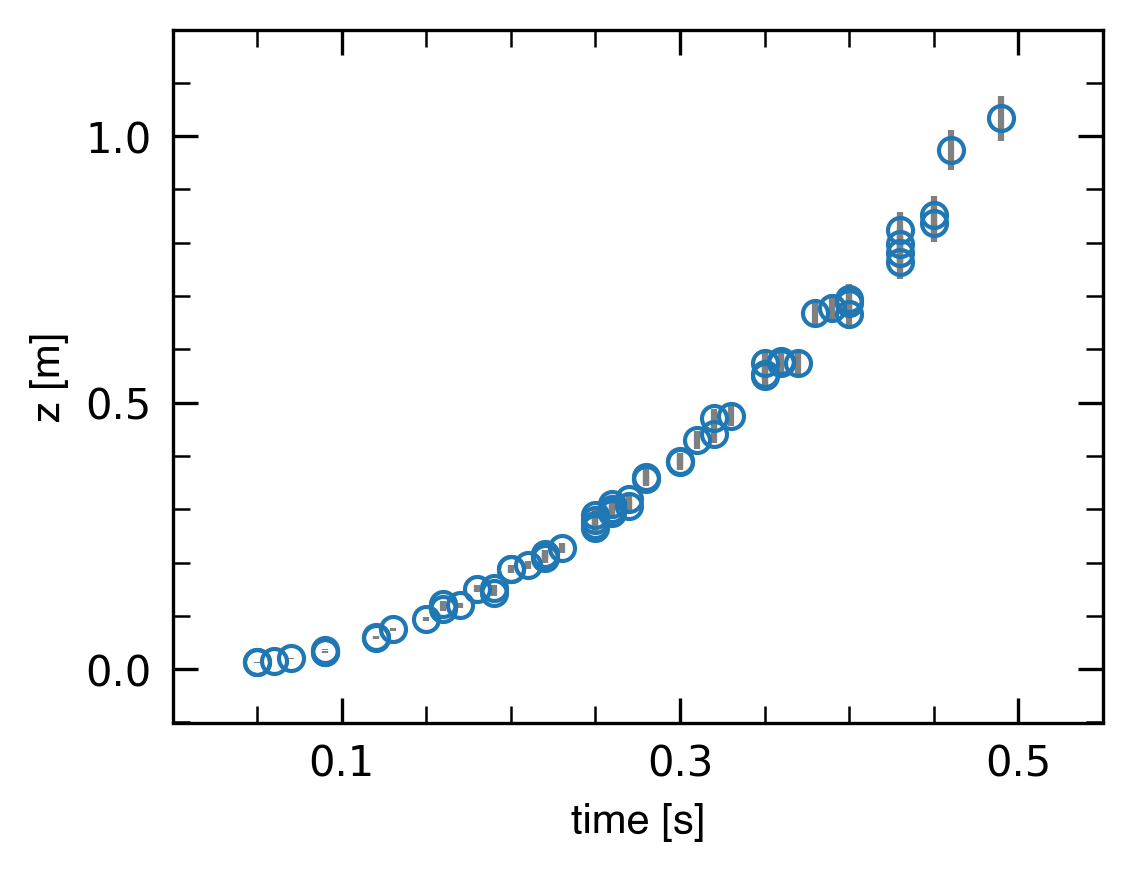

In [3]:
# import the data
free_fall_data_df = pd.read_csv(
    'https://raw.githubusercontent.com/cjtu/spirl/master/spirl/data/position_measurement_as.csv')

# visualise
fig, axis = plt.subplots(1, 1, figsize=(4, 3), dpi=300)

axis.errorbar(
    x=free_fall_data_df['time(s)'], y=free_fall_data_df['z(m)'],
    yerr=free_fall_data_df['z_err(m)'],
    fmt='o', mec='tab:blue', mfc='None', ecolor='grey', capsize=0
)
# set axis properties
axis.tick_params(axis='both', right=True, top=True, pad=5,
                 direction='in', length=6, which='major')
axis.tick_params(axis='both', right=True, top=True, pad=5,
                 direction='in', length=4, which='minor')

axis.set_xlabel('time [s]', fontname='Helvetica')
axis.set_xlim(0, .55)
axis.xaxis.set_major_locator(plt.MultipleLocator(.2, offset=.1))
axis.xaxis.set_minor_locator(plt.MultipleLocator(.05))

axis.set_ylabel('z [m]', fontname='Helvetica')
axis.set_ylim(-.1, 1.2)
axis.yaxis.set_major_locator(plt.MultipleLocator(.5))
axis.yaxis.set_minor_locator(plt.MultipleLocator(.1))

In [4]:
t = free_fall_data_df['time(s)'].to_numpy()
z = free_fall_data_df['z(m)'].to_numpy()
z_err = free_fall_data_df['z_err(m)'].to_numpy()

# Find the Planet Mass the Radius with different priors 

In [5]:
def model(t, M, R):
    return 0.5 * G_cgs * M * Mj2si / (R * Rj2si) ** 2 * t ** 2


def log_likelihood(theta, t, z, z_err):
    M, R = theta
    z_model = model(t, M, R)
    return -0.5 * np.sum(((z - z_model) / z_err) ** 2)


def log_probability(theta, t, z, z_err, log_prior):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, t, z, z_err)

## Uniform priors for both $M$ and $R$
- Prior for $M$: $M\sim\mathcal{U}(0, 0.1)$
- Prior for $R$: $R\sim\mathcal{U}(0, 1)$

In [6]:
def log_prior_both_uniform(theta):
    M, R = theta
    if 0 < M < 0.1 and 0 < R < 1:
        return 0.0
    return -np.inf

## Gaussian prior for $M$ and uniform prior for $R$
- Prior for $M$: $M\sim\mathcal{G}(0.045, 0.02)$
- Prior for $R$: $R\sim\mathcal{U}(0, 1)$

In [7]:
def log_prior_M_gaussian_R_uniform(theta):
    M, R = theta
    if 0 < R < 1:
        return -0.5 * ((M - 0.045) / 0.02) ** 2
    return -np.inf

## Gaussian priors for both $M$ and $R$
- Prior for $M$: $M\sim\mathcal{G}(0.045, 0.02)$
- Prior for $R$: $R\sim\mathcal{G}(0.357, 0.05)$

In [8]:
def log_prior_both_gaussian(theta):
    M, R = theta
    return -0.5 * ((M - 0.045) / 0.02) ** 2 - 0.5 * ((R - 0.357) / 0.05) ** 2

## Find the planet mass and radius with different priors

In [9]:
# MCMC sampler
n_walkers, n_dim = 100, 2
init_guess = np.array([0.05, 0.5])
pos = init_guess + 1e-4 * np.random.randn(n_walkers, n_dim)

prior_set_dict = {
    'both_uniform': log_prior_both_uniform,
    'M_gaussian-R_uniform': log_prior_M_gaussian_R_uniform,
    'both_gaussian': log_prior_both_gaussian
}

MCMC_results = {}
for prior_set_name, log_prior in prior_set_dict.items():
    # noinspection PyTypeChecker
    sampler = emcee.EnsembleSampler(
        n_walkers, n_dim, log_probability, args=(t, z, z_err, log_prior))

    print(f'\nRunning MCMC with {prior_set_name} priors...')
    sampler.run_mcmc(pos, 50000, progress=True)
    samples = sampler.get_chain(discard=1000, flat=True)

    M_samples, R_samples = samples.T
    M_mean, M_std = np.mean(M_samples), np.std(M_samples)
    R_mean, R_std = np.mean(R_samples), np.std(R_samples)

    MCMC_results[prior_set_name] = {
        'samples': samples,
        'M_mean': M_mean,
        'M_std': M_std,
        'R_mean': R_mean,
        'R_std': R_std
    }
    print(f'{prior_set_name} priors:'
          f'\nMean M: {M_mean:.3f}\u00B1{M_std:.3f}'
          f'\nMean R: {R_mean:.3f}\u00B1{R_std:.3f}')



Running MCMC with both_uniform priors...


100%|██████████| 50000/50000 [00:54<00:00, 911.61it/s]


both_uniform priors:
Mean M: 0.062±0.025
Mean R: 0.408±0.092

Running MCMC with M_gaussian-R_uniform priors...


100%|██████████| 50000/50000 [00:59<00:00, 840.50it/s]


M_gaussian-R_uniform priors:
Mean M: 0.051±0.018
Mean R: 0.371±0.071

Running MCMC with both_gaussian priors...


100%|██████████| 50000/50000 [01:02<00:00, 797.86it/s]


both_gaussian priors:
Mean M: 0.048±0.011
Mean R: 0.365±0.041


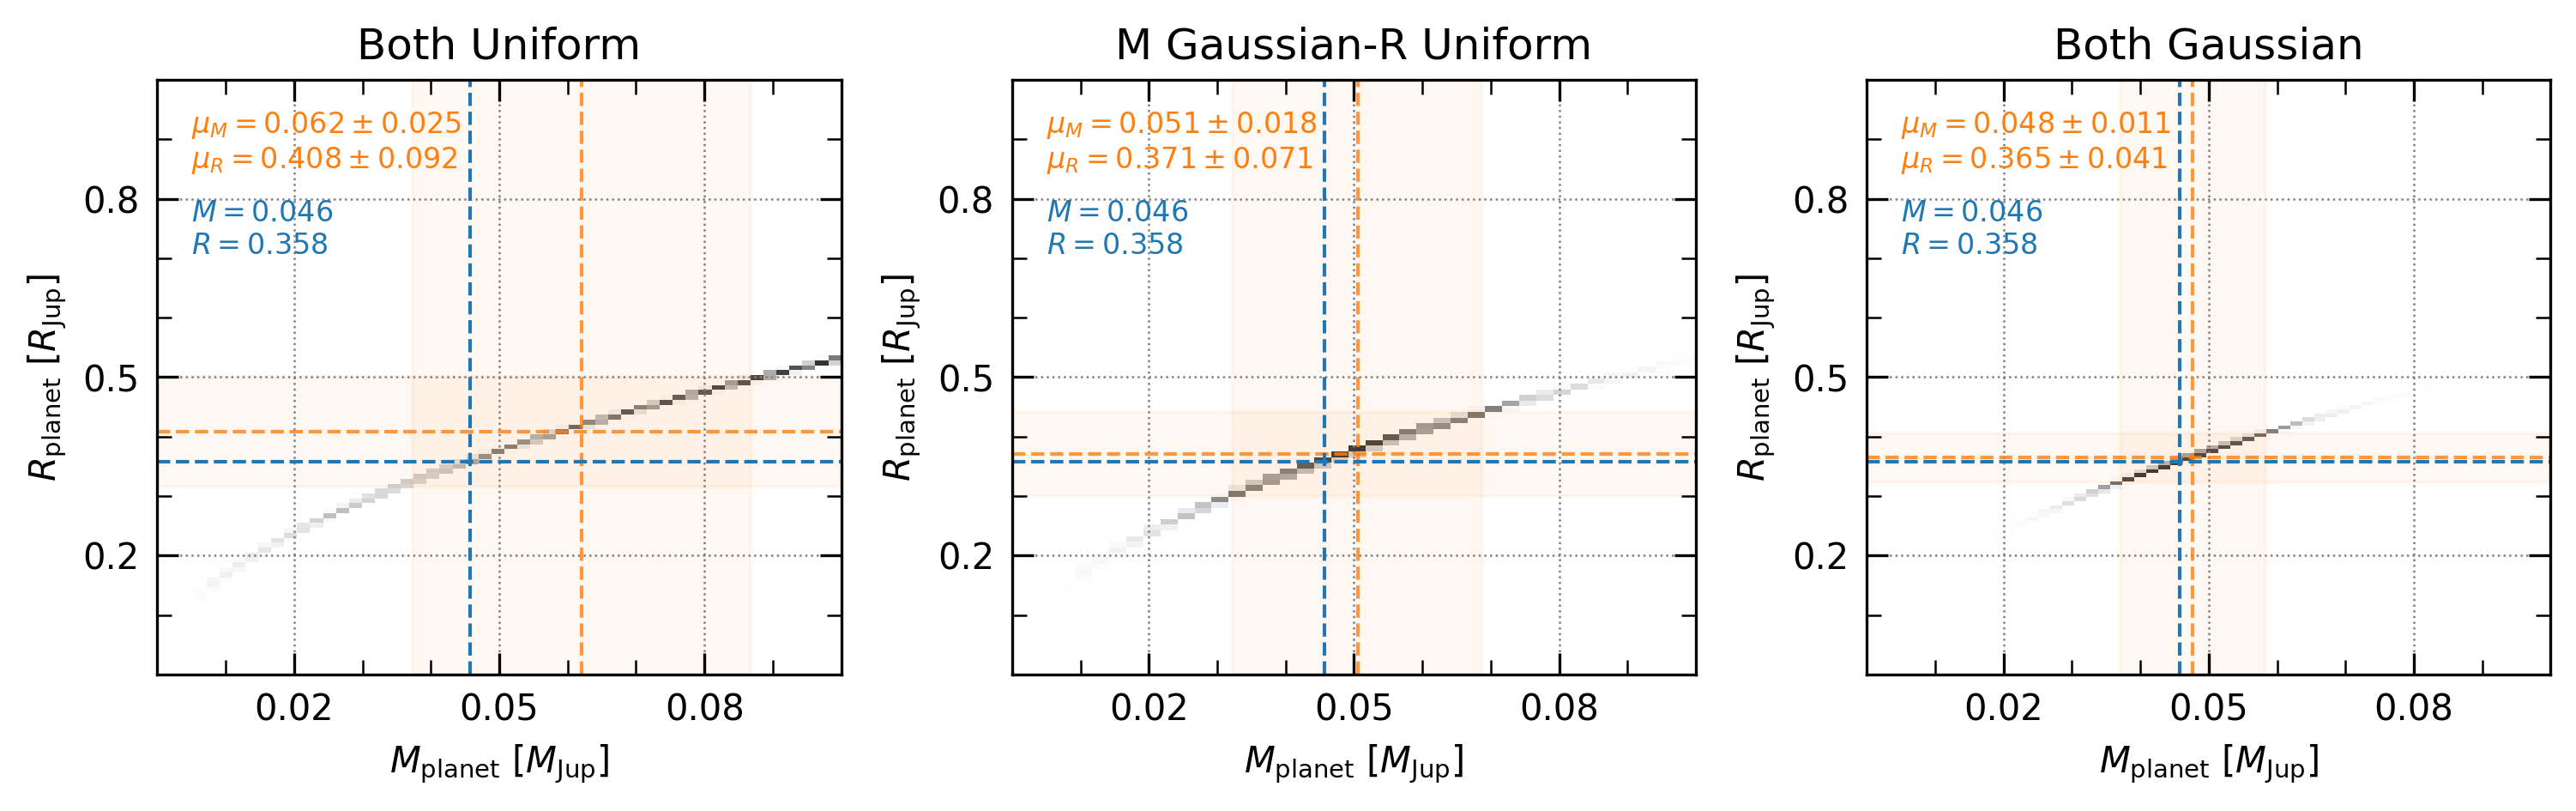

In [10]:
fig, axes = plt.subplots(
    1, 3, figsize=(12, 3), dpi=300, gridspec_kw=dict(wspace=.25))

for axis, (prior_set_name, result) in zip(axes, MCMC_results.items()):
    axis.hist2d(result['samples'][:, 0], result['samples'][:, 1],
                bins=50, cmap='Greys', alpha=.8, zorder=-1)

    # plot the mean and std of M and R
    axis.axvline(result['M_mean'], color='tab:orange', ls='--', lw=1, alpha=.8)
    axis.axvspan(result['M_mean'] - result['M_std'], result['M_mean'] + result['M_std'],
                 color='tab:orange', alpha=.05, zorder=-1)
    axis.axhline(result['R_mean'], color='tab:orange', ls='--', lw=1, alpha=.8)
    axis.axhspan(result['R_mean'] - result['R_std'], result['R_mean'] + result['R_std'],
                 color='tab:orange', alpha=.05, zorder=-1)
    # annotate the mean and std of M and R
    axis.text(.05, .95,
              f'$\mu_M={result["M_mean"]:.3f}\pm{result["M_std"]:.3f}$\n'
              f'$\mu_R={result["R_mean"]:.3f}\pm{result["R_std"]:.3f}$',
              color='tab:orange', fontsize=8,
              transform=axis.transAxes, ha='left', va='top')

    # plot the true value of M and R
    axis.axvline(true_M, color='tab:blue', ls='--', lw=1)
    axis.axhline(true_R, color='tab:blue', ls='--', lw=1)
    # annotate the true value of M and R
    axis.text(.05, .80,
              f'$M={true_M:.3f}$\n$R={true_R:.3f}$',
              color='tab:blue', fontsize=8,
              transform=axis.transAxes, ha='left', va='top')

    # set axis properties
    axis.set_xlabel('$M_\mathrm{planet}$ [$M_\mathrm{Jup}$]')
    axis.set_xlim(0, 0.1)
    axis.xaxis.set_major_locator(plt.MultipleLocator(.03, offset=.02))
    axis.xaxis.set_minor_locator(plt.MultipleLocator(.01))

    axis.set_ylabel('$R_\mathrm{planet}$ [$R_\mathrm{Jup}$]')
    axis.set_ylim(0, 1)
    axis.yaxis.set_major_locator(plt.MultipleLocator(.3, offset=.2))
    axis.yaxis.set_minor_locator(plt.MultipleLocator(.1))

    axis.set_title(prior_set_name.replace('_', ' ').title())

    axis.tick_params(axis='both', right=True, top=True, pad=5,
                     direction='in', length=6, which='major')
    axis.tick_params(axis='both', right=True, top=True, pad=5,
                     direction='in', length=4, which='minor')
    axis.grid(which='major', ls=':', lw=.6, color='grey')
